In [10]:
import glob
import numpy as np
import matplotlib.colors as col
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [11]:
#note the micro_code has been edited to fit to the cryotemp experiment

class A:
#    f = 45e3; # set frequency in Hz
    A = np.loadtxt('./76_25_5_measurements.txt') # load cantilever data

#    rot1 = 0 # quadrature angle measured by pd_lock
#    split = 0.02 #split between pd_lock and pd_sqz
def micro_code_freq(f,rot2,dL,P):
   # print(dL)
    pi = np.pi
    rot2 = rot2
    Te=25 #Sample temp
    L=0.01
    P = P*0.3#10e-3*0.3#6.5*0.3e-3 #max #.0035#
    #P = 3.6e-4 #Original
    Pp = 0
    Loss = 220e-6
    T1 = 50e-6
    T2 = 450e-6
    #dL = -4.0 #-2#-1/np.sqrt(3)
    dLp = 0
    Q0 = 17000.
    readout_angle=0
    rot1=0
    #A????
    hbar=1e-34
    lambda1 = 1064e-9 #lambda is protected in python, find later instances of it
    c=3e8
    w0 = 2*np.pi*(3e8)/(1064e-9)
    split = 0.5

    
    class results:
          iM = 0

          Pcirc = 0

          Pcircp = 0

          psd1 = 0

          psd2 = 0

          coh = 0

          cpsd =0

          RPN = 0

          RPN_p = 0

          RPNT = 0

          xsql  = 0

          RPN2 = 0

          chi = 0

          TN = 0

          RPNX = 0
          
          TS = 0

    L = L
    Loss = Loss
    Pin = P #power input

    #We think we have only about 5% coupling (for the IC side) from measuring Pin after the PBS
    #and what actually gets in the cavity.
    #We think we have close to 80% efficiency on the cantilever side based on
    #power measurements before and after a fiber.

    #For adding losses, change input power to keep circulating power the same.
    #Pin = Pin*(1+R1*R2-2*sqrt(R1)*sqrt(R2))/(1+(R1+Loss)*R2-2*sqrt(R1+Loss)*sqrt(R2))
    #Pin = Pin*(1+R1*R2-2*sqrt(R1)*sqrt(R2))/(1+(R1+Loss)*R2-2*sqrt(R1+Loss)*sqrt(R2))

    #To add losses, make T+R not equal 1. Can lump together all scattering and
    #absorption into one place.

    T1 = T1
    R1 = 1-T1-Loss
    T2 = T2
    R2 = 1-T2

    dL = dL#% detuning in linewidths
    dL = dL*lambda1*(T1+T2+Loss)/8/pi

    f = f

    #Thermal

    MT = 2e-4/(A.A[:,1])**2*5000
    MT[0] = 50e-12
    #MT=MT*1e30;

    Te=Te # temperature
    Q0 = Q0 #CT/358*10e3;

    #f = logspace(3,6,10000);
    #TT = THv(f,M(1),A(1,1),A(1,2),Te); % thermal noise
    TT=0
    TS=0

    def THv(f,m,Rf,Q,T):
        hbar = 1.05e-34
        kb = 1.3707e-23
        kbT = kb * T
        c=3e8
        O = f*2*pi
        Of = Rf*2*pi
        x = np.sqrt((4*kbT/m)/(Of*Q)*(Of**2)/((Of**2-O**2)**2+Of**4/Q**2))
        return x

    def THN(f,m,Rf,Q,T):
        hbar = 1.05e-34
        kb = 1.3707e-23
        kbT = kb * T
        c=3e8
        O = f*2*pi
        Of = Rf*2*pi
        x = np.sqrt((4*kbT/m)/(O*Q)*(Of**2)/((Of**2-O**2)**2+Of**4/Q**2))
        return x

    TT = np.sqrt(TT**2+THv(f,MT[0],A.A[0,0],Q0,Te)**2) # thermal noise
    TS = np.sqrt(TS**2+THN(f,MT[0],A.A[0,0],Q0,Te)**2) # thermal noise
    
    S = 1/MT[0]/(2*pi)**2/(f**2-A.A[0,0]**2-1.0j*f*A.A[0,0]/Q0) #susceptibility


    #print (f**2-A.A[0,0]**2-1j*f*A.A[0,0]/Q0)
    for j in range(2,len(MT)): #THIS 1 WAS CHANGED FROM A 2
        Q = Q0

        TT = np.sqrt(TT**2+THv(f,MT[j],A.A[j,0],Q,Te)**2)
        TS = np.sqrt(TS**2+THN(f,MT[j],A.A[j,0],Q,Te)**2)

        S = S + 1/MT[j]/(2*pi)**2/(f**2-A.A[j,0]**2-1j*f*A.A[j,0]/Q) # susceptibility
        
    results.TS = TS #Thermal noise model with no thermoelastic damping (thats TT)
    #DC FIELDS
    M0 = np.zeros((8,8),dtype=complex)
    for z in range(0,8):
        M0[z,z] = -1

    M0[1,0] = np.sqrt(R1) #b = rho1 * a + tau1*d
    M0[1,3] = np.sqrt(T1)

    M0[2,0] = np.sqrt(T1) #c = tau1 * a - rho1*d
    M0[2,3] = -np.sqrt(R1)

    M0[3,5] = np.exp(1j*w0*dL/c) # d gets phase shift from length
    M0[4,2] = np.exp(1j*w0*dL/c) # e gets ...


    M0[5,4] = -np.sqrt(R2) # f = -rho2*e + tau2*h
    M0[5,7] = np.sqrt(T2)
    M0[6,4] = np.sqrt(T2) # g = tau2*e + rho2*h
    M0[6,7] = np.sqrt(R2)

    M0[7,7] = 1; 

    iM0 = np.matrix(M0).I

    P = []

    for z in np.arange(8):
        P.append(iM0[z,0]*np.sqrt(Pin))

    #Circulating Power
    #Print out circulating power so we can check if it stays constant
    results.Pcirc = abs(P[2])**2

    ####SIDEBANDS#####
    M = np.zeros((32,32),dtype=complex)
    for z in range(0,32):
        M[z,z] = -1

    a1 = 0
    a2 = 1
    b1 = 2
    b2 = 3
    c1 = 4
    c2 = 5
    d1 = 6
    d2 = 7
    e1 = 8
    e2 = 9
    f1 = 10
    f2 = 11
    g1 = 12
    g2 = 13
    h1 = 14
    h2 = 15
    X = 16 #small displacement on end mirror
    F = 17  #force on end mirror
    r1 = 18
    r2 = 19
    t1 = 20
    t2 = 21
    j1 = 22
    j2 = 23
    k1 = 24
    k2 = 25
    l1 = 26
    l2 = 27
    m1 = 28
    m2 = 29
    n1 = 30
    n2 = 31

    O = -2*pi*f

    M[b1,a1] = np.sqrt(R1) # b = rho1*a + tau1*d
    M[b1,d1] = np.sqrt(T1) 
    M[b2,a2] = np.sqrt(R1)
    M[b2,d2] = np.sqrt(T1)

    M[c1,a1] = np.sqrt(T1) # c = tau1*a - rho1*d
    M[c1,d1] = -np.sqrt(R1)
    M[c2,a2] = np.sqrt(T1)
    M[c2,d2] = -np.sqrt(R1)
    
    M[d1,f1] = np.exp(1j*O*L/c)*np.cos(w0*dL/c) # phase shift and rotation from free space 
    M[d1,f2] = np.exp(1j*O*L/c)*np.sin(w0*dL/c)*-1
    M[d2,f1] = np.exp(1j*O*L/c)*np.sin(w0*dL/c)
    M[d2,f2] = np.exp(1j*O*L/c)*np.cos(w0*dL/c)

    M[e1,c1] = np.exp(1j*O*L/c)*np.cos(w0*dL/c)
    M[e1,c2] = np.exp(1j*O*L/c)*np.sin(w0*dL/c)*-1
    M[e2,c1] = np.exp(1j*O*L/c)*np.sin(w0*dL/c)
    M[e2,c2] = np.exp(1j*O*L/c)*np.cos(w0*dL/c)

    mag = 2*np.sqrt(R2)*w0/c/np.sqrt(hbar*w0)*np.sqrt(2)# coupling of X to reflected field

    
    M[f1,X] = mag*np.imag(P[4])
    M[f2,X] = -mag*np.real(P[4])

    M[X,F] = S; # suspectibility2) = -sqrt(R1)

    mag = np.sqrt(hbar*w0/c**2) # radiation pressure on end mirror
    Pe = P[4]
    Pf = P[5]
    Pg = P[6]
 

    M[F,e1] = np.sqrt(2)*np.real(Pe)*mag
    M[F,e2] = np.sqrt(2)*np.imag(Pe)*mag
    M[F,f1] = np.sqrt(2)*np.real(Pf)*mag
    M[F,f2] = np.sqrt(2)*np.imag(Pf)*mag
    M[F,g1] = np.sqrt(2)*np.real(Pg)*mag
    M[F,g2] = np.sqrt(2)*np.imag(Pg)*mag


    M[f1,e1] = -np.sqrt(R2) # f = tau1*h - rho1*e
    M[f1,h1] = np.sqrt(T2)
    M[f2,e2] = -np.sqrt(R2)
    M[f2,h2] = np.sqrt(T2)

    M[g1,e1] = np.sqrt(T2) # g = rho1*e + tau1*h
    M[g1,h1] = np.sqrt(R2)  
    M[g2,e2] = np.sqrt(T2)
    M[g2,h2] = np.sqrt(R2)

    M[r1,b1] = np.cos(-np.angle(P[1]))
    M[r1,b2] = -np.sin(-np.angle(P[1]))
    M[r2,b1] = np.sin(-np.angle(P[1]))
    M[r2,b2] = np.cos(-np.angle(P[1]))

    readout_angle = readout_angle
    M[t1,g1] = np.cos(-np.angle(P[6])+readout_angle)
    M[t1,g2] = -np.sin(-np.angle(P[6])+readout_angle)
    M[t2,g1] = np.sin(-np.angle(P[6])+readout_angle)
    M[t2,g2] = np.cos(-np.angle(P[6])+readout_angle)

    # split output
    rs = np.sqrt(split)
    ts = np.sqrt(1-rs**2)
    M[j1,t1] = rs
    M[j2,t2] = rs
    M[l1,t1] = ts
    M[l2,t2] = ts
    M[j1,n1] = ts
    M[j2,n2] = ts
    M[l1,n1] = -rs
    M[l2,n2] = -rs


    #rotate outputs
    rot1 = rot1
    M[k1,j1] = np.cos(rot1)
    M[k1,j2] = -np.sin(rot1)
    M[k2,j1] = np.sin(rot1)
    M[k2,j2] = np.cos(rot1)

    rot2 = rot2
    M[m1,l1] = np.cos(rot2)
    M[m1,l2] = -np.sin(rot2)
    M[m2,l1] = np.sin(rot2)
    M[m2,l2] = np.cos(rot2)
    #for i in range(32):
    #    for j in range(32):
    #        print M[i,j]

    iM = np.matrix(M).I

    #RESULTS#

    results.cpsd = iM[k1,a1] * iM[m1,a1].conjugate() + iM[k1,a2] * iM[m1,a2].conjugate() + iM[k1,h1] * iM[m1,h1].conjugate() +\
        iM[k1,h2] * iM[m1,h2].conjugate()+((Loss))*iM[k1,b1] * iM[m1,b1].conjugate()+((Loss))*iM[k1,b2] * iM[m1,b2].conjugate()+\
        ((Loss))*iM[k1,c1] * iM[m1,c1].conjugate()+((Loss))*iM[k1,c2] * iM[m1,c2].conjugate()+\
        iM[k1,n1] * iM[m1,n1].conjugate() + iM[k1,n2] * iM[m1,n2].conjugate()+\
        TS**2*iM[k1,X] * iM[m1,X].conjugate()*0
    results.cpsd = np.sqrt(np.abs(results.cpsd/(iM[k1,X] * iM[m1,X].conjugate())))

    results.psd1 = iM[k1,a1] * iM[k1,a1].conjugate() + iM[k1,a2] * iM[k1,a2].conjugate() + iM[k1,h1] * iM[k1,h1].conjugate() + iM[k1,h2] * iM[k1,h2].conjugate()+\
        ((Loss))*iM[k1,b1] * iM[k1,b1].conjugate()+((Loss))*iM[k1,b2] * iM[k1,b2].conjugate()+\
        ((Loss))*iM[k1,c1] * iM[k1,c1].conjugate()+((Loss))*iM[k1,c2] * iM[k1,c2].conjugate()+\
        iM[k1,n1] * iM[k1,n1].conjugate() + iM[k1,n2] * iM[k1,n2].conjugate()+\
        TS**2*iM[k1,X] * iM[k1,X].conjugate()
    results.psd1 = np.sqrt(results.psd1/(iM[k1,X] * iM[k1,X].conjugate()))

    results.psd2 = iM[m1,a1] * iM[m1,a1].conjugate() + iM[m1,a2] * iM[m1,a2].conjugate() + iM[m1,h1] * iM[m1,h1].conjugate() + iM[m1,h2] * iM[m1,h2].conjugate()+\
        ((Loss))*iM[m1,b1] * iM[m1,b1].conjugate()+((Loss))*iM[m1,b2] * iM[m1,b2].conjugate()+\
        ((Loss))*iM[m1,c1] * iM[m1,c1].conjugate()+((Loss))*iM[m1,c2] * iM[m1,c2].conjugate()+\
        iM[m1,n1] * iM[m1,n1].conjugate() + iM[m1,n2] * iM[m1,n2].conjugate()+\
        TS**2*iM[m1,X] * iM[m1,X].conjugate()*0
    results.psd2 = np.sqrt(results.psd2/(iM[m1,X] * iM[m1,X].conjugate()))
    
    #our measured noise * element^
    results.RPN2 = iM[m1,a1] * iM[m1,a1].conjugate() + iM[m1,a2] * iM[m1,a2].conjugate() + iM[m1,h1] * iM[m1,h1].conjugate() + iM[m1,h2] * iM[m1,h2].conjugate()+\
        ((Loss))*iM[m1,b1] * iM[m1,b1].conjugate()+((Loss))*iM[m1,b2] * iM[m1,b2].conjugate()+\
        ((Loss))*iM[m1,c1] * iM[m1,c1].conjugate()+((Loss))*iM[m1,c2] * iM[m1,c2].conjugate()+\
        iM[m1,n1] * iM[m1,n1].conjugate() + iM[m1,n2] * iM[m1,n2].conjugate() #total quantum noise

    results.coh = abs(results.cpsd)**2 / results.psd1 / results.psd2


    results.RPN = (abs(iM[t1,a1]))**2 + (abs(iM[t1,a2]))**2 + (abs(iM[t1,h1]))**2 + (abs(iM[t1,h2]))**2 +\
         ((Loss))*(abs(iM[t1,b1]))**2 + ((Loss))*(abs(iM[t1,b2]))**2 +\
         ((Loss))*(abs(iM[t1,c1]))**2 + ((Loss))*(abs(iM[t1,c2]))**2
    results.RPNT = results.RPN + abs(iM[t1,X]*TS)**2

    #This tells us the motion caused by the optical fields
    results.RPNX = np.sqrt((abs(iM[X,a1]))**2 + (abs(iM[X,a2]))**2 + (abs(iM[X,h1]))**2 + (abs(iM[X,h2]))**2 +\
        ((Loss))*(abs(iM[X,b1]))**2 + ((Loss))*(abs(iM[X,b2]))**2 +\
        ((Loss))*(abs(iM[X,c1]))**2 + ((Loss))*(abs(iM[X,c2]))**2)

    # iM(k1,a1)
    #results.iM = iM; %
    results.chi = iM[X,F]
    results.chi = S

    results.xsql = np.sqrt(2*1e-34*abs(S))  #SQL using susceptibility

    thermal_TF_SQ = (iM[m1,X]*iM[m1,X].conjugate())
    
    thermal = abs(iM[t1,X]) * TS
    
    CIN = abs(iM[t1,a1])
    
    OS_TF = abs(iM[k1,a1])
    
    
    
    return  results.psd2,results.psd1,results.cpsd, TS, results.xsql, results.chi
    #return results.psd2,results.coh,results.RPNT,results.RPN2,thermal_TF_SQ,OS_TF,results.psd1,results.TS

-2.5


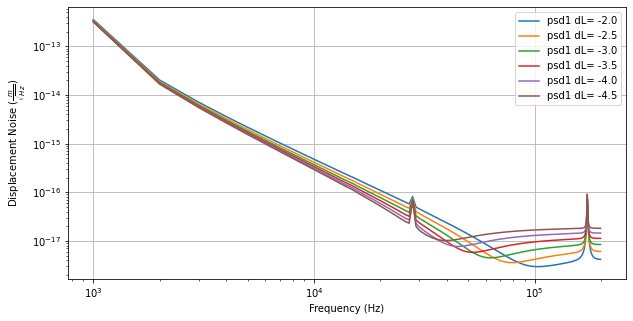

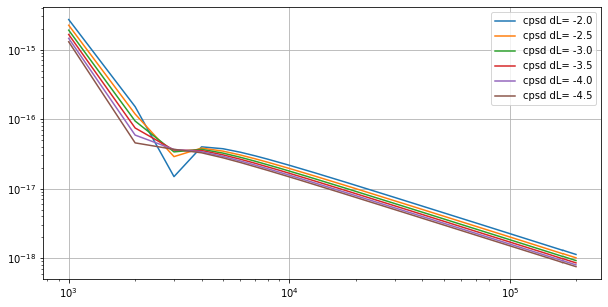

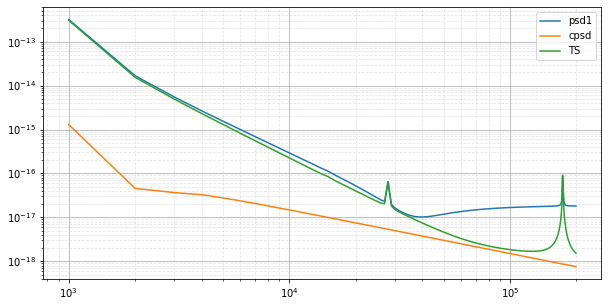

In [8]:
pi = np.pi
A.rot1 = 0 # quadrature angle measured by pd_lock
A.A = np.loadtxt('./76_25_5_measurements.txt')
A.split = 0.5 #split between pd_lock and pd_sqz

phi = 0
freq = np.arange(1000,200000,1000.0)#7e4
psd1 = []
psd2 = []
cpsd = []
TS = []
rpnt = []
xsql = []
chi = []
P = 4.3e-3
dL = np.arange(-2,-5,-.5)#np.array([-4.5]) #
plt.figure(1,figsize=(10,5))
plt.figure(2,figsize=(10,5))
ii = 1
print(dL[ii])#dL[ii]
for ii in np.arange(len(dL)):
    for j in np.arange(len(freq)):
        rot2 = phi
        freq1 = freq[j]

        B = micro_code_freq(freq1,rot2,dL[ii],P)#dL[ii]
        psd2.append(B[0])
        psd1.append(B[1])
        cpsd.append(B[2])
        TS.append(B[3])
        xsql.append(B[4])
        chi.append(B[5])

    lab = 'psd1 dL= %.1f' % (dL[ii])#dL[ii]
    lab2 = 'cpsd dL= %.1f' % (dL[ii])
    plt.figure(1)
    plt.grid()
    plt.grid(True)
    plt.loglog(freq,np.abs(np.array(psd1)),label=lab)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Displacement Noise ($\\frac{m}{\\sqrt{Hz}}$)')
    plt.grid(which='minor',linestyle='--',alpha = 0.3)
    plt.legend()
    
    plt.figure(2)
    plt.grid()
    plt.grid(True)
    plt.grid(which='minor',linestyle='--',alpha = 0.3)
    plt.loglog(freq,np.abs(np.array(cpsd)),label=lab2)
    plt.legend()
    #print(ii)
    #print(len(dL))
    endCnt = len(dL)-1
    if ii < (endCnt):
        psd1 = []
        psd2 = []
        cpsd = []
        TS = []
        xsql = []
#     print(dL)
plt.figure(3,figsize=(10,5))
plt.loglog(freq,np.abs(np.array(psd1)),label='psd1')
plt.loglog(freq,np.abs(np.array(cpsd)),label='cpsd')
plt.loglog(freq,np.abs(np.array(TS)),label='TS')
plt.grid()
plt.grid(True)
plt.grid(which='minor',linestyle='--',alpha = 0.3)
plt.legend()
# plt.loglog(freq,np.abs(np.array(xsql)))

-3.5
[0.001 0.006]
0
ch
1
[0.001 0.006]


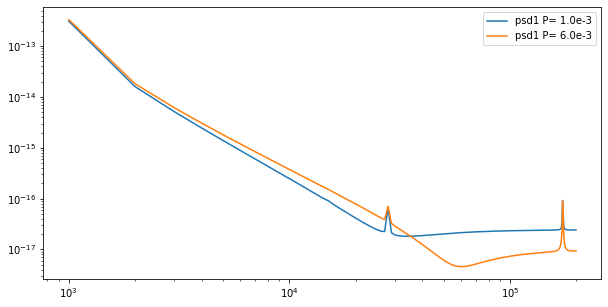

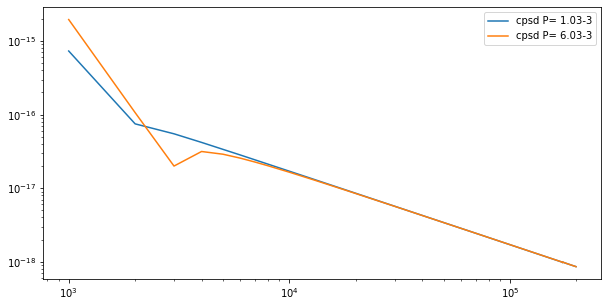

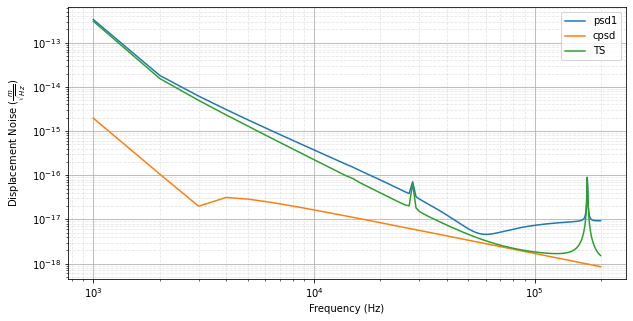

In [17]:
pi = np.pi
A.rot1 = 0 # quadrature angle measured by pd_lock
A.A = np.loadtxt('./76_25_5_measurements.txt')
A.split = 0.5 #split between pd_lock and pd_sqz

phi = 0
freq = np.arange(1000,200000,1000.0)#7e4
psd1 = []
psd2 = []
cpsd = []
TS = []
rpnt = []
xsql = []
chi = []
dL = -3.5 #np.arange(-2,-5,-.5)#np.array([-4.5]) #
P = np.array([1e-3, 6e-3])#np.arange(1,10,2.5)*1e-3
plt.figure(1,figsize=(10,5))
plt.figure(2,figsize=(10,5))
ii = 1
print(dL)#dL[ii]
print(P)
for ii in np.arange(len(P)):
    print(ii)
    for j in np.arange(len(freq)):
        rot2 = phi
        freq1 = freq[j]

        B = micro_code_freq(freq1,rot2,dL,P[ii])#dL[ii]
        psd2.append(B[0])
        psd1.append(B[1])
        cpsd.append(B[2])
        TS.append(B[3])
        xsql.append(B[4])
        chi.append(B[5])

    lab = 'psd1 P= %.1fe-3' % (P[ii]*1e3)#dL[ii]
    lab2 = 'cpsd P= %.1f3-3' % (P[ii]*1e3)
    plt.figure(1)
    plt.loglog(freq,np.abs(np.array(psd1)),label=lab)
    plt.legend()
    
    plt.figure(2)
    plt.loglog(freq,np.abs(np.array(cpsd)),label=lab2)
    plt.legend()
    #print(ii)
    #print(len(dL))
    endCnt = len(P)-1
    if ii < (endCnt):
        print('ch')
        psd1 = []
        psd2 = []
        cpsd = []
        TS = []
        xsql = []
#     print(dL)
plt.figure(3,figsize=(10,5))
plt.loglog(freq,np.abs(np.array(psd1)),label='psd1')
plt.loglog(freq,np.abs(np.array(cpsd)),label='cpsd')
plt.loglog(freq,np.abs(np.array(TS)),label='TS')
plt.legend()
plt.grid()
plt.grid(True)
plt.minorticks_on()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Displacement Noise ($\\frac{m}{\\sqrt{Hz}}$)')
plt.grid(which='minor',linestyle='--',alpha = 0.3)
# plt.loglog(freq,np.abs(np.array(xsql)))

print(P)

In [14]:
print(P)


[0.001  0.0035 0.006  0.0085]


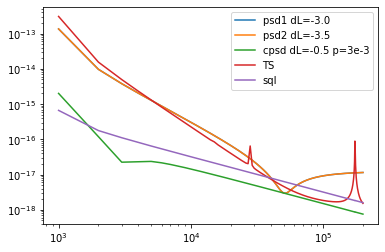

In [5]:


hbar = 1e-34
w0 = 2*np.pi*(3e8)/(1064e-9) 
#SN = np.sqrt(2*hbar*w0/Pow)

plt.figure(1)
plt.loglog(freq,np.abs(np.array(psd1)),label='psd1 dL=-3.0')
plt.loglog(freq,np.abs(np.array(psd2)),label='psd2 dL=-3.5')
# plt.loglog(freq,np.abs(np.array(psd2)),label = 'psd2')
plt.loglog(freq,np.abs(np.array(cpsd)),label = 'cpsd dL=-0.5 p=3e-3')
# plt.loglog(freq,np.abs(np.array(cpsd2)),label = 'cpsd dL=-1 p=5e-3')# 
# plt.loglog(freq,np.abs(np.array(cpsd3)),label = 'cpsd dL=-2 p=10e-3')#')
# plt.loglog(freq,np.abs(np.array(cpsd4)),label = 'cpsd dL=-3 p=15e-3')#')
# plt.loglog(freq,np.abs(np.array(cpsd5)),label = 'cpsd dL=-4 p=25e-3')#')
# plt.loglog(freq,np.abs(np.array(cpsd6)),label = 'cpsd dL=-5 p=30e-3')#')
#plt.loglog(freq,np.abs(np.array(cpsd7))*np.sqrt(3),label = 'cpsd dL=-6')
# plt.loglog(freq,np.abs(np.array(cpsd8))*np.sqrt(3),label = 'cpsd dL=-7')
plt.loglog(freq,np.array(TS),label = 'TS')
plt.loglog(freq,np.array(xsql),label = 'sql')
#plt.loglog(freq,SN*np.sqrt(np.array(rpnt)-np.array(thermal)**2),label = 'QN')
#plt.loglog(freq,SN*np.array(np.sqrt(rpnt)),label = 'QN+Thermal')
#plt.ylim(0,.01)
plt.legend()
plt.show()

In [34]:
# print(len(cpsd6))
# print(len(freq))
# len(dL)-1
A = np.loadtxt('./76_25_5_measurements.txt')
print(A)
A.A


[[ 8.77000000e+02  1.59136699e+05]
 [ 3.69500000e+03  1.00000000e+04]
 [ 1.52300000e+04  7.00000000e+01]
 [ 2.81300000e+04  1.50000000e+02]
 [ 1.73349655e+05 -1.43657055e+03]
 [ 2.17092289e+05  1.01760733e-01]
 [ 4.75026881e+05  1.41279800e+03]
 [ 8.78313449e+05  5.93222754e+03]
 [ 9.31566159e+05 -9.60526483e+02]
 [ 1.54269367e+06  1.01381803e+03]
 [ 1.59980163e+06  2.47136554e+00]
 [ 2.31114905e+06 -9.58977921e+02]
 [ 3.21393492e+06  1.35562099e+01]
 [ 3.23911224e+06  9.67181191e+02]
 [ 3.63144479e+06  3.68526173e-02]
 [ 4.32842706e+06 -1.04599249e+03]
 [ 4.85697028e+06 -1.81729903e+00]
 [ 5.58264098e+06 -1.20035098e+03]
 [ 6.54250244e+06  3.82401102e+00]
 [ 7.00012064e+06 -1.19110162e+03]
 [ 7.62094683e+06 -7.64893636e+02]
 [ 7.62899541e+06  6.37399551e+03]
 [ 8.28341987e+06 -1.53464991e+01]
 [ 8.60135346e+06  3.22419867e+03]
 [ 9.64363329e+06  3.63672255e-01]
 [ 1.00936702e+07 -5.06002531e+01]
 [ 1.03601679e+07 -5.61617349e+03]
 [ 1.19851498e+07 -1.83981162e+02]
 [ 1.22917898e+07  2

AttributeError: 'numpy.ndarray' object has no attribute 'A'

In [ ]:
#Meas = np.loadtxt('/home/qol/Documents/Scott/G2.35v_Y1v_ISS_off_test_5_11/FFT1.dat')

In [ ]:
#freq = np.arange(1000,1000000,100)
#freq2 = np.arange(1000,1000000,len(Meas))

#plt.figure(1)
#plt.loglog(freq,np.array(thermal)*SN,label='thermal')
#plt.loglog(freq,np.array(CIN)*SN,label = 'CIN')
#plt.loglog(freq,SN*np.sqrt(np.array(rpnt)-np.array(thermal)**2),label = 'QN')
#plt.loglog(freq,SN*np.array(np.sqrt(rpnt)),label = 'QN+Thermal')

#plt.loglog(Meas[:,0],Meas[:,1]/2.35,label = 'Measured')
#plt.ylim(1e-8,1e-6)
#plt.xlim(1e3,1e5)
#plt.legend()
#plt.show()

In [ ]:
((100000**2-50000**2))

In [ ]:
freq = np.array([1000.0, 10000.0, 100000.0])
test = (freq**2-50000**2)
plt.plot(freq,np.abs(test))

In [ ]:
print(test)
print(freq[2])

In [ ]:
print(np.angle(1j))

In [ ]:
plt.loglog(freq,np.abs(chi))

In [ ]:
fft1 = np.loadtxt('\\Data7_22/2V_PDLock_28K')